Author :Appau Ernest
> Team-Lead - Team Lisa






> AIM -In this notebook, we aim to build  convolutional Neural Network  model from  the 
 generated ESC-50 Generating dataset3 based on log-scaled and delta combined mel-spectogram portfolios generated to classify sound events (in image format in our goal to capture Illegal chainsaw activity through chainsaw sounds.This notebook contains final Iteration model  version  1 and its evaluation and performance metrics.Other models iterations will follow up in subsequent seperate notebooks based on other generated datasets, Feature engineering techniques and deep learning architectures
  



> This Notebook's activites are dividied into:


1.  Downloading ,Analysing and Exploring the Generated Dataset
2.  Building a dataset 
3.  building a convnet with a vgg16 model as a feature extractor  
4.  Evaluating the perfomance of our model in categorising and detecting audio events especially chainsaw activity (testing on converted-Image portfolios)



> links to the ESC-50 dataset based on log-scaled and delta combined mel-spectogram portfolios


*   Target and class labels(Csv format) - 
*   Meta_data file for the datasets (csv format) -
*  ESC-50-logscaled_delta_melspec-combined dataset (zip format)-


> To_do- Move files to  github and change the links above when done 














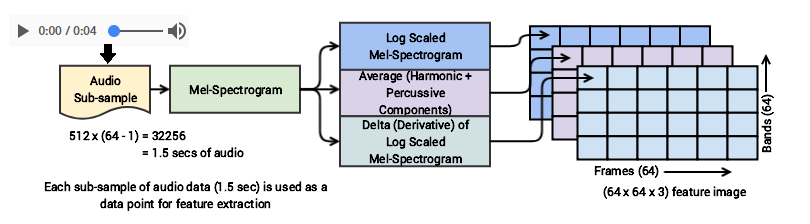

The feature engineering process we are going to utilise here is detailed in the above image: 

1.   we will using a total of three feature representation maps which will us three dimensional images , they include :



*   Log-scaled MelSpectogram
*   Average(Harmonic + Percussive components
*   Delta-Derivative of logscaled mel spectogram

We are adopting this idea from Karol Piczak paper on environmental sound classification but improving upon the transformations of our representation maps



Methodology used to realise the above approach include 


1.   create a base melspectogram of our audio sample 
2.   create a log scaled spectogram as a feature map 1
3. create Average harmonic and percusive log scaled melspectogram from our base spectogram as our feature map 2
4.  create a derivative log scaled spectogram as a feature map 3 known a s delta 

with the feature map 1,2,3 we we combine them as an 64 by 64 scaled image with 3 channels thus getting a 3D feature map of dimensions (64,64,3)






**Exploration and Preprocessing**

We download our dataset and explore  it

In [2]:
# download and extract our dataset 
!wget 'https://github.com/karoldvl/ESC-50/archive/master.zip'

--2020-10-27 21:23:30--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2020-10-27 21:23:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/master [following]
--2020-10-27 21:23:31--  https://codeload.github.com/karolpiczak/ESC-50/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [       <=>         

In [3]:
# we extract our data 
!unzip master.zip

Archive:  master.zip
9b2663c92e6b4cc87ed16f00fa9a3a6038a862b3
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-master/.circleci/config.yml  
   creating: ESC-50-master/.github/
  inflating: ESC-50-master/.github/stale.yml  
 extracting: ESC-50-master/.gitignore  
  inflating: ESC-50-master/LICENSE   
  inflating: ESC-50-master/README.md  
   creating: ESC-50-master/audio/
  inflating: ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC-50-master/audio/1-101296-A-19.wav  
  inflating: ESC-50-master/audio/1-101296-B-19.wav  
  inflating: ESC-50-master/audio/1-101336-A-30.wav  
  inflating: ESC-50-master/audio/1-101404-A-34.wav  
  inflating: ESC-50-master/audio/1-103298-A-9.wav  
  inflating: ESC-50-master/audio/1-103995-A-30.wav  
  inflating: ESC-50-master/audio/1-103999-A-30.wav  
  infla

In [ ]:
#  install sound file
!pip install soundfile


In [ ]:
# Import the required datasets 
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
import IPython.display as ipd
import glob  
from matplotlib.pyplot import specgram 
import librosa.display 
import IPython.display 
import soundfile as sf 
from sklearn.externals import joblib 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# We load our ESC-50  dataset files
soundfiles = glob.glob('/content/ESC-50-master/audio/*')
soundfiles[1]

'/content/ESC-50-master/audio/1-115920-B-22.wav'

In [ ]:
#we listen to various sample audio files in the esc-50 dataset
e=1
for i in soundfiles: 
  print(i ,':' )
  print('_____')
  IPython.display.display(IPython.display.Audio(data = str(i) , filename=str(i)))
  e+=1
  if e == 5:
    break

/content/ESC-50-master/audio/3-167096-A-31.wav :
_____


/content/ESC-50-master/audio/1-115920-B-22.wav :
_____


/content/ESC-50-master/audio/3-216280-A-39.wav :
_____


/content/ESC-50-master/audio/4-194680-A-36.wav :
_____


**Feature Engineering**

we generate feature maps to buyild our dataset 

In [ ]:
# we define some utility functions load raw sound 
def get_sound_data(path, sr=22050): 
    data, fsr = sf.read(path) 
    data_resample = librosa.resample(data.T, fsr, sr) 
    if len(data_resample.shape) > 1: 
        data_resample = np.average(data_resample, axis=0) 
    return data_resample, sr 


# function to get start and end indices for audio sub-sample 
def windows(data, window_size): 
    start = 0 
    while start < len(data): 
        yield int(start), int(start + window_size) 
        start += (window_size / 2) 


In [ ]:
#  write function to implement the workflow above to generate feature 
# implementation

def feature_extractor(file_names, bands=64, frames=64): 
    window_size = 512 * (frames - 1)   
    log_specgrams_full = [] 
    log_specgrams_hp = [] 
    class_labels = [] 
    
    # for each audio sample 
    for fn in file_names: 
        file_name = fn.split('-')[5] 
        class_label = file_name.split('.')[0] 
        sound_data, sr = get_sound_data(fn, sr=22050) 

        # for each audio signal sub-sample window of data 
        for (start,end) in windows(sound_data, window_size): 
            if(len(sound_data[start:end]) == window_size): 
                signal = sound_data[start:end] 

                # get the log-scaled mel-spectrogram 
                melspec_full = librosa.feature.melspectrogram(signal, 
                                                              n_mels = 
                                                                 bands) 
                logspec_full = librosa.amplitude_to_db(melspec_full) 
                logspec_full = logspec_full.T.flatten()[:,np.newaxis].T 

                # get the log-scaled, averaged values for the  
                # harmonic and percussive components 
                y_harmonic, y_percussive =librosa.effects.hpss(signal) 
                melspec_harmonic =  librosa.feature.melspectrogram(y_harmonic,n_mels=bands)   
                                                         
                melspec_percussive = librosa.feature.melspectrogram(y_percussive,   
                                                       n_mels=bands)  
                         
                logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic) 
                       
                logspec_percussive = librosa.amplitude_to_db(melspec_percussive) 
                       
                logspec_harmonic = logspec_harmonic.T.flatten()[:, 
                                                          np.newaxis].T 
                logspec_percussive = logspec_percussive.T.flatten()[:,  
                                                          np.newaxis].T 
                logspec_hp = np.average([logspec_harmonic,  
                                        logspec_percussive],  
                                        axis=0) 
                log_specgrams_full.append(logspec_full) 
                log_specgrams_hp.append(logspec_hp) 
                class_labels.append(class_label) 
    
    # create the first two feature maps             
    log_specgrams_full = np.asarray(log_specgrams_full).reshape( 
                                        len(log_specgrams_full), bands,  
                                        frames, 1) 
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape( 
                                        len(log_specgrams_hp), bands,   
                                        frames, 1) 
    features = np.concatenate((log_specgrams_full,  
                               log_specgrams_hp,                                  
                               np.zeros(np.shape( 
                                      log_specgrams_full))),  
                               axis=3) 
    
    # create the third feature map which is the delta (derivative)    
    # of the log-scaled mel-spectrogram 
    for i in range(len(features)): 
        features[i, :, :, 2] = librosa.feature.delta(features[i,   
                                                              :, :, 0]) 
    return np.array(features), np.array(class_labels, dtype = np.int) 



In [ ]:
# check current working dir
!pwd

/content


In [ ]:
# we generate the feature maps based on the utility func above
features, labels = feature_extractor(soundfiles) 

# sanity check
# display the shape of our features and their labels
features.shape, labels.shape 

((10000, 64, 64, 3), (10000,))

In [ ]:
# check the overall class representations of our data
from collections import Counter 
# returns class label and sample pair 
Counter(labels) 

Counter({0: 200,
         1: 200,
         2: 200,
         3: 200,
         4: 200,
         5: 200,
         6: 200,
         7: 200,
         8: 200,
         9: 200,
         10: 200,
         11: 200,
         12: 200,
         13: 200,
         14: 200,
         15: 200,
         16: 200,
         17: 200,
         18: 200,
         19: 200,
         20: 200,
         21: 200,
         22: 200,
         23: 200,
         24: 200,
         25: 200,
         26: 200,
         27: 200,
         28: 200,
         29: 200,
         30: 200,
         31: 200,
         32: 200,
         33: 200,
         34: 200,
         35: 200,
         36: 200,
         37: 200,
         38: 200,
         39: 200,
         40: 200,
         41: 200,
         42: 200,
         43: 200,
         44: 200,
         45: 200,
         46: 200,
         47: 200,
         48: 200,
         49: 200})

ValueError: ignored

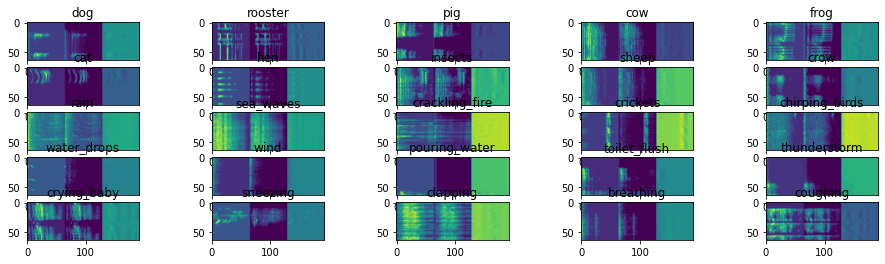

In [ ]:
# we visuals generated feature maps for the sound files 
id_class = {'0':	'dog',
'14' :	'chirping_birds',
'36'	 : 'vacuum_cleaner',
	'19'	 : 'thunderstorm',
	'30'	 : 'door_wood_knock',
	'34'	:  'can_opening',
	'9'	:  'crow',
	'22'	: 'clapping',
	'48'	:  'fireworks',
	'41'	:  'chainsaw',
'47' :	'airplane',
	'31'	:  'mouse_click',
	'17'  :	'pouring_water',
	'45' :	'train',
'8'	: 'sheep',
	'15'	:  'water_drops',
	'46'	: 'church_bells',
	'37'	:  'clock_alarm',
	'32'	:  'keyboard_typing',
	'16'	:  'wind',
'25'	 :  'footsteps',
	'4'	:  'frog',
	'3':  'cow',
	'27' :	'brushing_teeth',
	'43'	: 'car_horn',
	'12'	:  'crackling_fire',
	'40' :	'helicopter',
	'29'	: 'drinking_sipping',
	'10' :	'rain',
	'7'	: 'insects',
	'26'	:  'laughing',
	'6'	: 'hen',
	'44'	: 'engine',
	'23'	: 'breathing',
	'20'	:  'crying_baby',
	'49'	:  'hand_saw',
	'24'	:  'coughing',
	'39'	: 'glass_breaking',
	'28'	: 'snoring',
	'18'	: 'toilet_flush',
	'2'	: 'pig',
	'35'	: 'washing_machine',
	'38'	 : 'clock_tick',
	'21'	: 'sneezing',
	'1'	: 'rooster',
	'11'	: 'sea_waves',
	'42'	: 'siren',
	'5'	: 'cat',
	'33'	: 'door_wood_creaks',
	'13'	: 'crickets'} 



categories  = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in 
               categories]
feature_samples = features[sample_idxs] 
  
plt.figure(figsize=(16, 4)) 
for index, (feature_map, category) in enumerate(zip(feature_samples,  
                                                    categories)): 
    plt.subplot(5, 5, index+1) 
    plt.imshow(np.concatenate((feature_map[:,:,0],  
                               feature_map[:,:,1],    
                               feature_map[:,:,2]),  
                               axis=1),
                               cmap='viridis') 
    plt.title(id_class[str(category)]) 
plt.tight_layout() 
t = plt.suptitle('Visual Feature Maps for Audio Clips,categories') 

In [ ]:
# we save the generated feature maps as images a  data set for future ref
# In the future, we just load the dataset as images and build our models 


# To-do

In [ ]:
# save feature maps to disk using joblib
joblib.dump(features, 'ESC-50-final_iter_features.pkl') 
joblib.dump(labels, 'ESC-50-final_iter_labels.pkl') 

['ESC-50-final_iter_labels.pkl']

In [ ]:
# save pkl files to drive 
!cp  "/content/ESC-50-final_iter_features.pkl" -r "/content/drive/My Drive"
!cp  "/content/ESC-50-final_iter_labels.pkl" -r "/content/drive/My Drive"


**Building our DataSet**

> lets build our dataset and split them into train and test splits  block




In [ ]:
#  load our features and labels 
features = joblib.load('ESC-50-final_iter_features.pkl') 
labels = joblib.load('ESC-50-final_iter_labels.pkl') 

# transform features and maps
# into am array of list pairs 
Gen_data = np.array(list(zip(features, labels))) 

#sanity: we check the shape 
features.shape, labels.shape 

((10000, 64, 64, 3), (10000,))

In [ ]:
# shuffle our data randomly 
np.random.shuffle(Gen_data) 

# create train,test,validation splits
train_set, validation_set, test_set = np.split(Gen_data, [int(.6*len(Gen_data)),int(.8*len(Gen_data))]) 

# sanity check
train_set.shape, validation_set.shape, test_set.shape 


((6000, 2), (2000, 2), (2000, 2))

In [ ]:
# check per classs distribution of our data
print('Train:', Counter(item[1] for item in train_set))
print('\nValidate:', Counter(item[1] for item in validation_set))
print('\nTest:',Counter(item[1] for item in test_set))

Train: Counter({44: 136, 19: 133, 29: 130, 47: 130, 37: 128, 5: 127, 22: 127, 45: 127, 0: 127, 15: 126, 49: 125, 25: 125, 11: 124, 31: 124, 33: 123, 38: 123, 10: 123, 30: 123, 7: 123, 46: 123, 34: 122, 3: 122, 12: 121, 42: 121, 26: 121, 39: 121, 24: 120, 18: 119, 36: 119, 2: 119, 41: 118, 32: 118, 14: 118, 6: 116, 9: 116, 23: 115, 43: 115, 35: 114, 40: 114, 1: 114, 20: 114, 21: 113, 8: 113, 28: 111, 4: 111, 17: 110, 48: 110, 27: 110, 16: 109, 13: 109})

Validate: Counter({17: 51, 26: 50, 35: 48, 4: 47, 24: 46, 6: 46, 40: 46, 25: 45, 13: 45, 14: 44, 16: 44, 28: 44, 36: 44, 30: 44, 8: 43, 39: 43, 31: 43, 48: 42, 23: 42, 1: 42, 3: 40, 32: 40, 12: 40, 10: 40, 41: 40, 27: 40, 46: 40, 38: 40, 34: 40, 21: 39, 9: 39, 2: 38, 22: 38, 0: 37, 43: 37, 33: 37, 7: 36, 42: 36, 15: 36, 11: 36, 44: 36, 18: 35, 29: 35, 20: 34, 49: 34, 47: 34, 37: 33, 5: 31, 19: 30, 45: 30})

Test: Counter({20: 52, 27: 50, 48: 48, 43: 48, 21: 48, 16: 47, 18: 46, 13: 46, 28: 45, 9: 45, 8: 44, 1: 44, 23: 43, 42: 43, 45: 43,

**Modeling Section**


> We will leverage transfer learning to build a final robust classifier for our dataset


In [ ]:
# we will use a vGG-16 model as feature extractor for our generated datset

In [ ]:
# import libraries
from keras.applications.imagenet_utils import preprocess_input 
from keras.preprocessing import image 
from PIL import Image 

# utility function to process sound data
def snd_processor(sound): 
    data = np.expand_dims(sound, axis=0)
    return data 

We load our VGG-16 modelas a feature extractor

In [ ]:
import keras
from keras.applications import vgg16
from keras.models import Model

# define vgg
vgg_16 = vgg16.VGG16(include_top = False,weights= 'imagenet',input_shape = (64,64,3))

# remove last layer because we will use it as a feature extractor
output =vgg_16.layers[-1].output
output =keras.layers.Flatten()(output)
model = Model(vgg_16.input,output)
model.trainable = False

# Visualise the model architecture
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)     

In [ ]:
# utility function to extract important features from our dataset 
def extract_features(model, base_feature_data): 
    dataset = [] 
    for index, feature_data in enumerate(base_feature_data):

        if (index+1) % 1000 == 0: 
            print('Finished processing', index+1, 'sound feature maps') 
        pr_data = snd_processor(feature_data) 
        # print(pr_data.shape())
        tl_features = model.predict(pr_data )
        tl_features = np.reshape(tl_features,  
                                  tl_features.shape[1]) 
        dataset.append(tl_features) 
    return np.array(dataset) 


In [ ]:
# we use our utility function from above to extract the
# features with our custom Vgg_16 model for our splits



# workflow
# 1-create a list of data files under each split set 
# 2-create a array list of labels for corresponding file in each split set 
# 3-pass both list above into the utility function extract features to
# return the dataset of unique features for each split




#  train datset feature extraction

train_data = [i[0] for i in train_set] 
train_labels = np.array([i[1] for i in train_set])
train_data_final =extract_features(model, train_data)
print('train_set done')
# test dataset feature extraction

test_data = [i[0] for i in test_set] 
test_labels =np.array([i[1] for i in test_set])
test_data_final =extract_features(model,test_data)
print('test_set done')


# validation dataset feature extraction

validation_data = [i[0] for i in validation_set] 
validation_labels =np.array([i[1] for i in validation_set])
validation_data_final =extract_features(model,validation_data)
print('validation_set done')



# sanity check : inspect the shape
train_data_final.shape, validation_data_final.shape, test_data_final.shape 


Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
Finished processing 3000 sound feature maps
Finished processing 4000 sound feature maps
Finished processing 5000 sound feature maps
Finished processing 6000 sound feature maps
train_set done
Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
test_set done
Finished processing 1000 sound feature maps
Finished processing 2000 sound feature maps
validation_set done


((6000, 2048), (2000, 2048), (2000, 2048))

In [ ]:

# save labels and features to disk for later use 
# Next time we want to train, we can start by using these files 
joblib.dump(train_data_final, 'train_data.pkl') 
joblib.dump(train_labels, 'train_labels.pkl') 
joblib.dump(validation_data_final, 'validation_data.pkl') 
joblib.dump(validation_labels, 'validation_labels.pkl') 
joblib.dump(test_data_final, 'test_data.pkl') 
joblib.dump(test_labels, 'test_labels.pkl') 

['test_labels.pkl']

Please mount your google drive  to save the data for future use 
You can use the mount note book button or the script below 

script to mount your google drive in notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive'

<!-- script to mount g -->

In [ ]:
# copy pkl files to my drive for future use 


!cp  "/content/train_data.pkl" -r "/content/drive/My Drive"
!cp  "/content/train_labels.pkl" -r "/content/drive/My Drive"
!cp  "/content/test_labels.pkl" -r "/content/drive/My Drive"
!cp  "/content/test_data.pkl" -r "/content/drive/My Drive"
!cp  "/content/validation_labels.pkl" -r "/content/drive/My Drive"
!cp  "/content/validation_data.pkl" -r "/content/drive/My Drive"



We build our classification Model

In [ ]:
# import libraries 
from sklearn.externals import joblib 
import keras 
from keras import models 
from keras import layers 
import matplotlib.pyplot as plt 

In [ ]:
# we load our data_splits and lables 


# load train data and labels
train = joblib.load('train_data.pkl') 
train_labels = joblib.load('train_labels.pkl') 

# load validation data and labels
validation = joblib.load('validation_data.pkl') 
validation_labels = joblib.load('validation_labels.pkl') 

# load test data and labels
test = joblib.load('test_data.pkl') 
test_labels = joblib.load('test_labels.pkl') 



In [ ]:
# sanity check>check the shape of our data
train.shape, validation.shape, test.shape 

((6000, 2048), (2000, 2048), (2000, 2048))

In [ ]:
# sanity check>check the shape of our label data
train_labels.shape, validation_labels.shape, test_labels.shape 

((6000,), (2000,), (2000,))

In [ ]:
# one hot encode our categorical model before feeding it to our deep learning model


# import categorical encoder
from keras.utils import to_categorical 

train_labels_encoded = to_categorical(train_labels) 
validation_labels_encoded= to_categorical(validation_labels) 
test_labels_encoded= to_categorical(test_labels) 

# sanity check:check shapes 
train_labels_encoded.shape, validation_labels_encoded.shape, test_labels_encoded.shape 


((6000, 50), (2000, 50), (2000, 50))

In [ ]:
# we build our deep learning model 

final_model = models.Sequential() 
final_model.add(layers.Dense(1024, activation='relu', 
          input_shape=(train.shape[1],))) 
final_model.add(layers.Dropout(0.4)) 
final_model.add(layers.Dense(1024, activation='relu')) 
final_model.add(layers.Dropout(0.4)) 
final_model.add(layers.Dense(512, activation='relu')) 
final_model.add(layers.Dropout(0.5)) 
final_model.add(layers.Dense(512, activation='relu')) 
final_model.add(layers.Dropout(0.5)) 
final_model.add(layers.Dense(train_labels_encoded.shape[1],activation='softmax')) 
final_model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
final_model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [ ]:
# we train for about 50 epochs
history = final_model.fit(train, train_labels_encoded,epochs=50, 
                    batch_size=100, 
                    validation_data=(validation,  
                    validation_labels_encoded),shuffle=True, verbose=1) 

Epoch 1/50
60/60 [==============================] - 4s 72ms/step - loss: 4.6985 - accuracy: 0.0317 - val_loss: 3.7265 - val_accuracy: 0.1370
Epoch 2/50
60/60 [==============================] - 4s 70ms/step - loss: 3.6733 - accuracy: 0.0800 - val_loss: 3.1850 - val_accuracy: 0.2225
Epoch 3/50
60/60 [==============================] - 4s 70ms/step - loss: 3.3174 - accuracy: 0.1402 - val_loss: 2.7406 - val_accuracy: 0.2630
Epoch 4/50
60/60 [==============================] - 4s 69ms/step - loss: 2.9556 - accuracy: 0.2188 - val_loss: 2.3878 - val_accuracy: 0.3535
Epoch 5/50
60/60 [==============================] - 4s 69ms/step - loss: 2.6780 - accuracy: 0.2677 - val_loss: 2.1849 - val_accuracy: 0.4250
Epoch 6/50
60/60 [==============================] - 4s 69ms/step - loss: 2.4828 - accuracy: 0.3193 - val_loss: 2.0520 - val_accuracy: 0.4640
Epoch 7/50
60/60 [==============================] - 4s 70ms/step - loss: 2.3249 - accuracy: 0.3640 - val_loss: 1.9365 - val_accuracy: 0.4825
Epoch 8/50
60

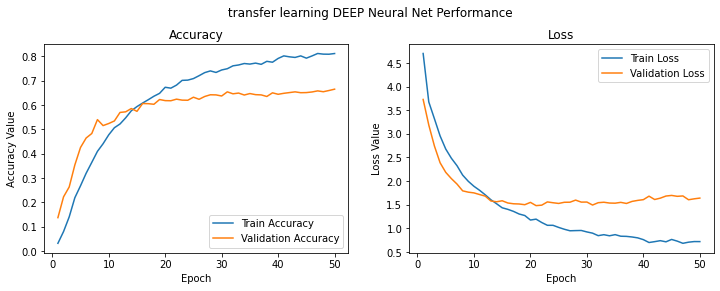

In [ ]:
# visualise our model training history

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 
t = f.suptitle(' transfer learning DEEP Neural Net Performance', fontsize=12) 
f.subplots_adjust(top=0.85, wspace=0.2) 
epochs = list(range(1,51)) 
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy') 
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy') 
ax1.set_ylabel('Accuracy Value') 
ax1.set_xlabel('Epoch') 
ax1.set_title('Accuracy') 
l1 = ax1.legend(loc="best") 
ax2.plot(epochs, history.history['loss'], label='Train Loss') 
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss') 
ax2.set_ylabel('Loss Value') 
ax2.set_xlabel('Epoch') 
ax2.set_title('Loss') 
l2 = ax2.legend(loc="best") 

we can observe from the abiove plot, our models accuracy and loss a fairely consistent and our model neither overfits or underfits, same applies with our validation metrics

We test and evaluate our models performance on our test set

In [ ]:
# We will need utility functions for to analyze the performance of our model




# ----------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 
import seaborn as sns

# ----------------------------------------------------------------------------------

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# ----------------------------------------------------------------------------------
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
 # ----------------------------------------------------------------------------------                       

 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
 # ----------------------------------------------------------------------------------   

# ----------------------------------------------------------------------------------

       
    

In [ ]:
# define bvariables  for test predictions and correponding true and predicted labels
test_predictions =final_model.predict_classes(test)
 
test_labels_categories = [id_class[str(label)]for label in test_labels]

prediction_labels_categories = [id_class[str(label)]for label in test_predictions]

category_names = list(id_class.values())

In [ ]:
# we check the metrics for our test experiment overal performance 
get_metrics(true_labels=test_labels_categories,  
                predicted_labels=prediction_labels_categories)

Accuracy: 0.6685
Precision: 0.7042
Recall: 0.6685
F1 Score: 0.671


The overal model accuracy and f1 score is close to 67 percent which is fairley consistent with observations in the validation sets

In [ ]:
# we check our metrics for perclass test performance 
display_classification_report(true_labels=test_labels_categories,     
                       predicted_labels=prediction_labels_categories,
                       classes=category_names) 

                  precision    recall  f1-score   support

             dog       0.63      0.47      0.54        36
  chirping_birds       0.82      0.82      0.82        38
  vacuum_cleaner       0.82      0.86      0.84        37
    thunderstorm       0.60      0.84      0.70        37
 door_wood_knock       0.54      0.42      0.47        33
     can_opening       0.25      0.39      0.31        38
            crow       0.85      0.51      0.64        45
        clapping       0.96      0.71      0.82        35
       fireworks       0.72      0.69      0.70        48
        chainsaw       0.65      0.88      0.75        42
        airplane       0.64      0.83      0.72        36
     mouse_click       0.43      0.45      0.44        33
   pouring_water       0.91      0.74      0.82        39
           train       0.61      0.84      0.71        43
           sheep       0.57      0.64      0.60        44
     water_drops       0.52      0.45      0.48        38
    church_be

Comments :
Our model seesms to have issues with classifying sneezing , coughing,aside from that the per class accuracies and f1 score are generalizing  to the test data.


> In our application, we hope to capture alerts regarding human activities 
chainsaw activities, handsaw activities and engine activity which provide an idication of a plausible illegal logging activity going on or emanatiing tus we can use the model



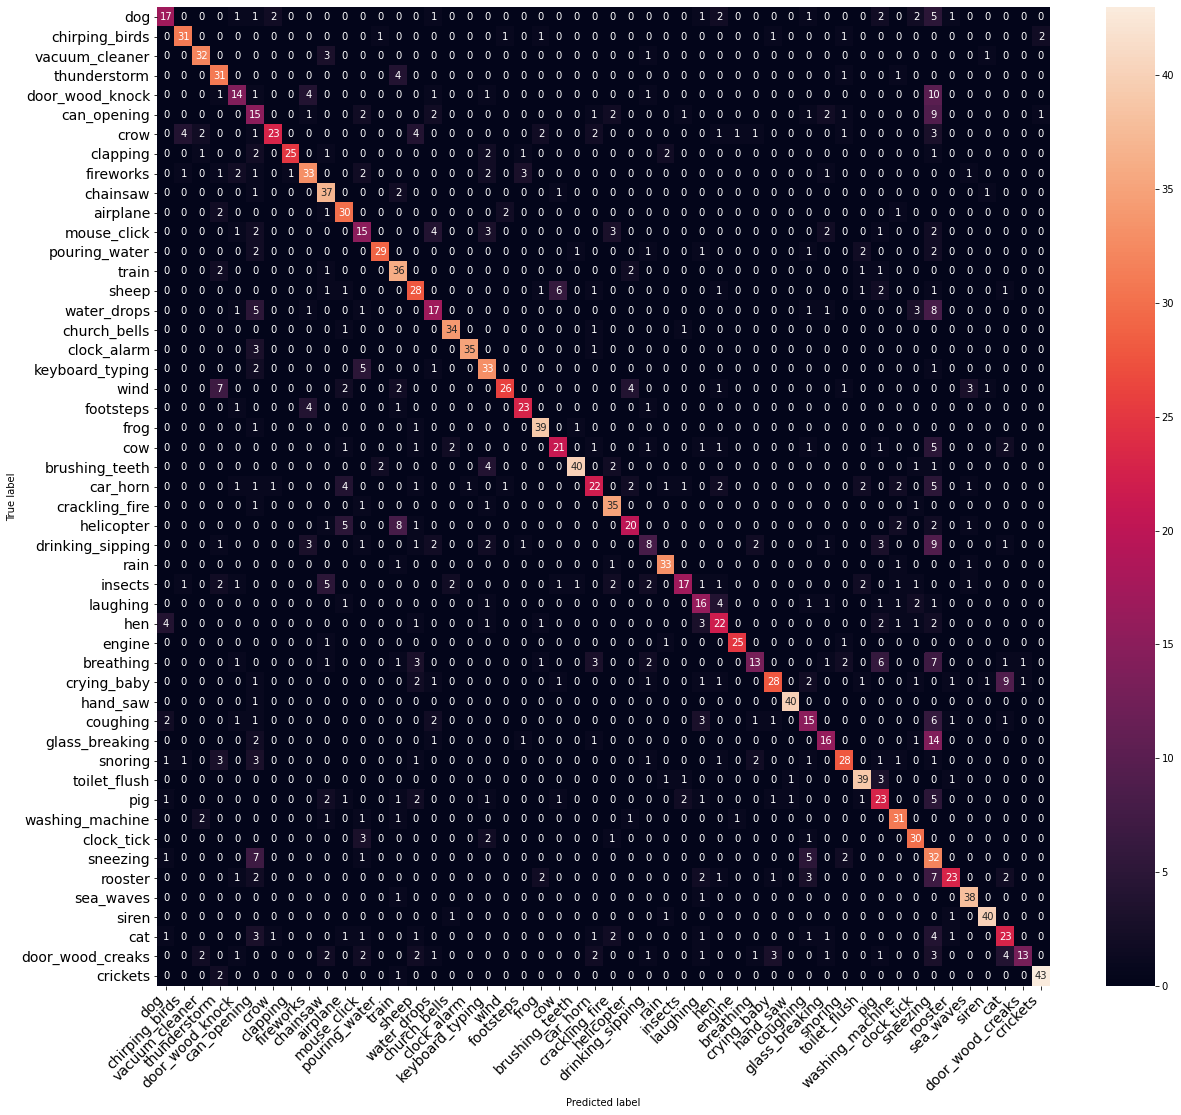

In [ ]:
# we visualise the confusion matrix
cm = metrics.confusion_matrix(test_labels_categories,     
                       prediction_labels_categories,
                       category_names) 

print_confusion_matrix(cm,category_names ,figsize =(20,18))

comments :
from the above visualisation, it can be observed that,sneezing,clock ticks,thunderstorm and door wood knocks among others had samples that were highly misclassified

> They dont really affect the application of our model because , the important classies relating to human and chainsaw activities can be correctly classiefied 



In [ ]:
# upon satisfactio, we save our model
final_model.save('illegal_logging_classifier_model.h5') 

In [ ]:
# we copy the model to the drive for future inference 
!cp  "/content/illegal_logging_classifier_model.h5" -r "/content/drive/My Drive"

**Building inference Pipeline**

> We build a complete inference pipeline for our model and test sample audio files on it

> This pipeline will serve as a mode of inference in the real world

> We will convert our model to a tensorflowlite version to enable it run on an iot device

1.   Please reference the tensorflowlite conversion notebook for steps on how the conversion was done











In [2]:
pip install soundfile

In [11]:
# we import essential models
!pip install soundfile
import librosa
import librosa.display
import soundfile as sf
import IPython.display
import numpy as np
import pandas as pd
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model
import keras
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# we write a class for illegal logging activity detection and prediction
class ForestSoundDetector:
    
    
    def __init__(self, prediction_model_path=None):
        self.vgg_model = self.load_vgg_model()
        self.prediction_model = self.load_prediction_model(prediction_model_path)
        self.id_class = {'0':	'dog',
'14' :	'chirping_birds',
'36'	 : 'vacuum_cleaner',
	'19'	 : 'thunderstorm',
	'30'	 : 'door_wood_knock',
	'34'	:  'can_opening',
	'9'	:  'crow',
	'22'	: 'clapping',
	'48'	:  'fireworks',
	'41'	:  'chainsaw',
'47' :	'airplane',
	'31'	:  'mouse_click',
	'17'  :	'pouring_water',
	'45' :	'train',
'8'	: 'sheep',
	'15'	:  'water_drops',
	'46'	: 'church_bells',
	'37'	:  'clock_alarm',
	'32'	:  'keyboard_typing',
	'16'	:  'wind',
'25'	 :  'footsteps',
	'4'	:  'frog',
	'3':  'cow',
	'27' :	'brushing_teeth',
	'43'	: 'car_horn',
	'12'	:  'crackling_fire',
	'40' :	'helicopter',
	'29'	: 'drinking_sipping',
	'10' :	'rain',
	'7'	: 'insects',
	'26'	:  'laughing',
	'6'	: 'hen',
	'44'	: 'engine',
	'23'	: 'breathing',
	'20'	:  'crying_baby',
	'49'	:  'hand_saw',
	'24'	:  'coughing',
	'39'	: 'glass_breaking',
	'28'	: 'snoring',
	'18'	: 'toilet_flush',
	'2'	: 'pig',
	'35'	: 'washing_machine',
	'38'	 : 'clock_tick',
	'21'	: 'sneezing',
	'1'	: 'rooster',
	'11'	: 'sea_waves',
	'42'	: 'siren',
	'5'	: 'cat',
	'33'	: 'door_wood_creaks',
	'13'	: 'crickets'} 

        self.predicted_class = None
        self.predicted_label = None
        
    #function for loading VGG 16 model 
    def load_vgg_model(self):
        vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))
        output = vgg_16.layers[-1].output
        output = keras.layers.Flatten()(output)
        model = Model(vgg_16.input, output)
        model.trainable = False
        return model
    
    # function for loading prediction model
    def load_prediction_model(self, model_path):
        pred_model = keras.models.load_model(model_path)
        return pred_model
    
    # function for loading raw sound files      
    def get_sound_data(self, path, sr=22050):
        data, fsr = sf.read(path)
        data_22k = librosa.resample(data.T, fsr, sr)
        if len(data_22k.shape) > 1:
            data_22k = np.average(data_22k, axis=0)
            
        return data_22k, sr
    
    # fuction to obtain the start and the end index of our audio
    def windows(self, data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size / 2) 
            
    # fuction to extract base features 
    def extract_base_features(self, sound_data, bands=64, frames=64):
    
        window_size = 512 * (frames - 1)  
        log_specgrams_full = []
        log_specgrams_hp = []
        
        start, end = list(self.windows(sound_data, window_size))[0]
        
        if(len(sound_data[start:end]) == window_size):
            signal = sound_data[start:end]

            melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec_full = librosa.amplitude_to_db(melspec_full)
            logspec_full = logspec_full.T.flatten()[:, np.newaxis].T

            y_harmonic, y_percussive = librosa.effects.hpss(signal)
            melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = bands)
            melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = bands)
            logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
            logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
            logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
            logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
            logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)

            log_specgrams_full.append(logspec_full)
            log_specgrams_hp.append(logspec_hp)

        log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
        log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
        features = np.concatenate((log_specgrams_full, 
                                   log_specgrams_hp, 
                                   np.zeros(np.shape(log_specgrams_full))), 
                                  axis=3)

        for i in range(len(features)):
            features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])

        return np.array(features)
    
    # function to extract features from our custom vgg model
    def extract_transfer_learn_features(self, base_feature_data):
        
        base_feature_data = np.expand_dims(base_feature_data, axis=0)
        model = self.vgg_model
        tl_features = model.predict(base_feature_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        return tl_features
    
    # function to perfom base feature extraction operation and transferlearning operations extraction
    def feature_engineering(self, audio_data):
        base_features = self.extract_base_features(sound_data=audio_data)
        final_feature_map = self.extract_transfer_learn_features(base_features[0])
        return final_feature_map
    
    # prediction function based on model
    def prediction(self, feature_map):
        model = self.prediction_model
        feature_map = feature_map.reshape(1, -1)
        pred_class = model.predict_classes(feature_map, verbose=0)
        return pred_class[0]

  
    # final prediction pipeline for keras model ,made up of the other util functions
    def prediction_pipeline(self, audio_file_path, return_class_label=True):
        
        audio_data, sr = self.get_sound_data(audio_file_path)
        feature_map = self.feature_engineering(audio_data)
        prediction_class = self.prediction(feature_map)
        self.predicted_class = prediction_class
        self.predicted_label = self.id_class[str(self.predicted_class)]  
        if return_class_label:
            return self.predicted_label
        else:
            return self.predicted_class
      
     

In [ ]:
# we load our keras model using our ForestSoundDetector class
ForestAI = ForestSoundDetector(prediction_model_path='/content/illegal_logging_classifier_model.h5')

In [ ]:
#sample audio files 
Chainsaw = '/content/ESC-50-master/audio/1-19898-B-41.wav'
handsaw = '/content/ESC-50-master/audio/1-18810-A-49.wav'
engine = '/content/ESC-50-master/audio/1-18527-A-44.wav'
fireworks = '/content/ESC-50-master/audio/2-117615-B-48.wav'

chainsaw_audio, chainsaw_sr = ForestAI.get_sound_data(Chainsaw)
handsaw_audio, handsaw_sr= ForestAI.get_sound_data(handsaw)
engine_audio,engine_sr =ForestAI.get_sound_data(engine)
fireworks_audio,fireworks_sr =ForestAI.get_sound_data(fireworks)

Real_sounds = ['chainsaw','handsaw','engine','fireworks']
Sound_data = [chainsaw_audio,handsaw_audio,engine_audio,fireworks_audio]
Sound_rate = [chainsaw_sr,handsaw_sr,engine_sr,fireworks_sr]
sound_file_path = [Chainsaw,handsaw,engine,fireworks]


In [ ]:
# we explore the audio samples 
for sound_class, data, sr in zip(Real_sounds, Sound_data, Sound_rate):
    print(sound_class, ':')
    IPython.display.display(IPython.display.Audio(data=data, rate=sr))


chainsaw :


handsaw :


engine :


fireworks :


In [ ]:
# we extract the  base feature map ectraction of the sample sounds

chainsaw_feature_map = ForestAI.extract_base_features(chainsaw_audio)[0]
engine_feature_map = ForestAI.extract_base_features(engine_audio)[0]
handsaw_feature_map = ForestAI.extract_base_features(handsaw_audio)[0]
fireworks_feature_map = ForestAI.extract_base_features(fireworks_audio)[0]
feature_maps = [chainsaw_feature_map, engine_feature_map,handsaw_feature_map ,fireworks_feature_map]

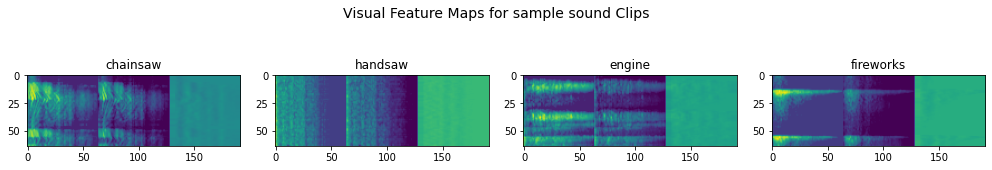

In [ ]:
from matplotlib import pyplot as plt 
#  we visualise the feature maps 
fig = plt.figure(figsize=(14, 3))
t = plt.suptitle('Visual Feature Maps for sample sound Clips', fontsize=14)
fig.subplots_adjust(top=0.8, wspace=0.1)
for index, (feature_map, category) in enumerate(zip(feature_maps, Real_sounds)):
    plt.subplot(1, 4, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(category)
plt.tight_layout(pad=1.5)

In [ ]:
# we perform predictions with our Keras Forest guard 
model_predictions = [ForestAI.prediction_pipeline(i , return_class_label = True) for i in sound_file_path]

In [ ]:
model_predictions

['chainsaw', 'hand_saw', 'engine', 'fireworks']

In [ ]:
dataframe_result = pd.DataFrame({'Actual Sound': Real_sounds,
                          'Predicted Sound': model_predictions,
                          'Location': sound_file_path})
dataframe_result 

Actual Sound Predicted Sound                                        Location
0     chainsaw        chainsaw   /content/ESC-50-master/audio/1-19898-B-41.wav
1      handsaw        hand_saw   /content/ESC-50-master/audio/1-18810-A-49.wav
2       engine          engine   /content/ESC-50-master/audio/1-18527-A-44.wav
3    fireworks       fireworks  /content/ESC-50-master/audio/2-117615-B-48.wav

we can conclude that, our Deep learning model has being able to classify all of our sound data correctly thus we have being able to achieve our goal of buildinga deep learning model to detect sounds that indicte the onset or continiuos occurence of illegal logging activities 

**FINAL KERAS PIPELINE**

In [ ]:
# final  Keras  pipeline



# define src audio data
Audio =''

# initialize the Forestguard AI  Model by passing in directory to the keras model
ForestGuardAI = ForestSoundDetector(prediction_model_path='/content/illegal_logging_classifier_model.h5')

# PASS THE SOUND FILE into the forest guard model
model_predictions = [ForestAI.prediction_pipeline(audio_file_path = Audio,return_class_label=True]
# check predictions
model_predictions
#  if sound corresponds to chainsaw or human activity, send an alert
# if not return nothing 
 '


FINAL TENSORFLOWLITE PIPELINE-tO_DO

In [ ]:
# convert keras model to tensorflow 
import tensorflow as tf
import keras
from keras.models import load_model
model = '/content/illegal_logging_classifier_model.h5'
model = load_model(model)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('ForestAI.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp735dtq81/assets


INFO:tensorflow:Assets written to: /tmp/tmp735dtq81/assets


In [ ]:
# save tensorflow  model to drive 
!cp  "/content/ForestAI.tflite" -r "/content/drive/My Drive"

In [ ]:
# final tensorflow pipeline for IOT Devices

# final  Keras  pipeline

# define src audio data
Audio =''

# initialize the Forestguard AI  Model by passing in directory to tensorflowlite  model
ForestGuardAI = ForestSoundDetector(prediction_model_path='')

# PASS THE SOUND FILE into the forest guard model
model_predictions = [ForestAI.prediction_pipeline(audio_file_path = Audio,return_class_label=True]
# check predictions
model_predictions
#  if sound corresponds to chainsaw or human activity, send an alert
# if not return nothing 
 '

In [21]:
# Final workflow for sending meta data to upon human or logging activity detection the raspberry pi

# install this library to help record audio files 
# !pip install sounddevice
# # !sudo apt-get install libportaudio2
# 
# import essential libraries 
import firebase_admin
from firebase_admin import credentials
from google.cloud import firestore
import os
import glob
import sounddevice as sd
from scipy.io.wavfile import write

# define the directories for the following files

# assign file audio path 
detected_audio =

# json file for firbase auth
jsonfile_dir = '/content/forest-guard-ai4good-firebase-adminsdk-1fw9p-232da17716.json'

# path to your inference model
inference_model_dir = '/content/drive/My Drive/illegal_logging_classifier_model.h5'

# specfic list of activities we want our model to detect 
activities_detected  = ['chainsaw','fireworks','engine','hand_saw','laughing','car_horn','brushing_teeth','footsteps','clapping','crackling_fire','coughing','snoring','sneezing','siren']


# configure the firestore realtime database
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=jsonfile_dir
if not firebase_admin._apps:
        cred = credentials.Certificate(jsonfile_dir) 
        default_app = firebase_admin.initialize_app(cred)

db = firestore.Client()
doc_ref = db.collection('activities').document('FpTJvCvMXNvKBHNZQ2WE')


# workflow------------------------------------------------------------------------------------
# while True:
# we stream and record the audio  from the microphone sensor in 5 sec clips, save them in a dir
# we use a for loop to pick the audio clip the dir and pass it through the model
# upon prediction we delete the audio from the dir or move the audio to another dir for future use 

# -----------------------------------------------------------------------------------------------

# initialize the Forestguard AI  Model by passing in directory to the keras model
ForestAI= ForestSoundDetector(prediction_model_path=inference_model_dir)

# function to detect human or illegal logging activities 
def set_status(snd):
      model_predictions = ForestAI.prediction_pipeline(audio_file_path = snd,return_class_label=True)
      status = model_predictions
      # for i in activities_detected:
      if status == activities_detected[0] or status == activities_detected[1] or status ==activities_detected[2] or status ==activities_detected[3]:
        doc_ref.set({'type':'1' })
      elif status in activities_detected:
        doc_ref.set({'type':'2' })
      else:
        doc_ref.set({'type':'0' })
        # block of code to save memory on iot device 
      # print(status)
      # os.remove(snd)
      # print("File Removed!")

        # to do rename and move from current dir to a different dir for storage
        
set_status(detected_audio)


# while True:
  
#   record wav 5 sec

#   fs = 44100 # Sample rate
#   seconds = 5  # Duration of recording
#   myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
#   sd.wait()  # Wait until recording is finished

#   # save wav in folder
#   write('recorded.wav', fs, myrecording)  # Save as WAV file 

#   pass into inference function
#   set_status('recorded.wav')

    


REFERENCES


1.   HANDS ON mathemathics for deep learning algorithms -Packt publishing
2.   Environmental Sound classification Paper 2015 by Karol Piczak
1.   Deep learning book by Ian Goodfellow and Yoshua Bengio
2.   Deep learning with Keras workshop by Packt Publishing
1.   Google search 
2.   Wikipaedia
2.   handouts by Superfluid labs and Ai4good meeetups
3. Mentors from Superfluid labs and AI4GOOD
3. https://keras.io/api/applications/
3. keras.io
3. TinyMl book
3. Tensorflow website 
